In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define hyperparameters
batch_size = 64 

# Set a random seed for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
# Define data transformations
transform = transforms.Compose( 
    [transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# Load the data
trainset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/train', transform=transform) 
testset = torchvision.datasets.ImageFolder(root='/Users/newuser/Projects/robust-algo-trader/cnn/test', transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# classes = ('won', 'loss')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        

for inputs, labels in train_loader:
    break

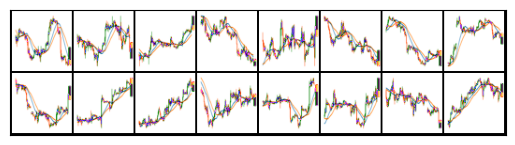

In [3]:
grid = make_grid([torch.squeeze(inputs[x]) for x in range(16)])
show(grid) 

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [5]:

# Define the model
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 5) # Input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Kernel size, stride
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        # Linear layers
        # self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc1 = nn.Linear(86528, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply the convolutional layers with pooling and dropout
        x = self.relu(self.conv1(x))
        # x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        # x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        # x = self.pool(x)
        
        x = self.dropout(x)
        # Flatten the output of the last convolutional layer
        x = torch.flatten(x, 1)
        # print("x.shape")
        # print(x.shape)
        # Apply the linear layers with dropout and sigmoid
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

cnn = CNNet()
cnn.to(device)

criterion = nn.BCELoss()
# learning_rate = 0.01
learning_rate = 0.001
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [6]:
# Define a function to compute accuracy
def accuracy(outputs, labels):
    predicted = torch.round(outputs)
    correct = (predicted == labels).sum().item()
    return 100 * correct / len(labels)


# Define test function
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss_sum, test_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            label = y.float().view(-1, 1)
            test_loss_sum += criterion(pred, label).item()
            test_correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()
    print(f"Test Loss: {test_loss_sum / num_batches}")
    print(f"Test Accuracy: {test_correct / size}")


# Define train function
def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss_sum, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        label = y.float().view(-1, 1)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        train_correct += (pred > 0.5).eq(y.view_as(pred)).sum().item()
    print(f"Train Loss: {train_loss_sum / num_batches}")
    print(f"Train Accuracy: {train_correct / size}")
    
epochs = 500_000_000
# epochs = 50
epochs = 5
for t in range(epochs):
    print("-------------------------------\n",
        f"Epoch {t+1}\n",
        "-------------------------------")
    train(train_loader, cnn, criterion, optimizer)
    test(test_loader, cnn, criterion)
print("Done!")

-------------------------------
 Epoch 1
 -------------------------------
Train Loss: 0.7040016431557504
Train Accuracy: 0.48657445077298617
Test Loss: 0.691464364528656
Test Accuracy: 0.57114493712773
-------------------------------
 Epoch 2
 -------------------------------
Train Loss: 0.6939594369185599
Train Accuracy: 0.4979658258746949
Test Loss: 0.693635906862176
Test Accuracy: 0.40304434149569823
-------------------------------
 Epoch 3
 -------------------------------
Train Loss: 0.6717353870994166
Train Accuracy: 0.6078112286411717
Test Loss: 0.5703351406947427
Test Accuracy: 0.7319655857048313
-------------------------------
 Epoch 4
 -------------------------------
Train Loss: 0.5683304243966153
Train Accuracy: 0.7054515866558178
Test Loss: 0.4945651448291281
Test Accuracy: 0.7478491065519524
-------------------------------
 Epoch 5
 -------------------------------
Train Loss: 0.49654470619402435
Train Accuracy: 0.7493897477624084
Test Loss: 0.480290517858837
Test Accuracy: 0

In [8]:

# Save the model
PATH = './model.pth'
# torch.save(cnn.state_dict(), PATH)

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained model
cnn = CNNet()
cnn.load_state_dict(torch.load(PATH))
cnn.to(device)
cnn.eval()


image = Image.open("plot.png").convert("RGB")
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

# # Get the model output
output = cnn(image)
print(f"The predicted class is {output}")

pred = torch.round(output)
# # Print the predicted class
print(f"The predicted class is {pred.item()}")

The predicted class is tensor([[0.4857]], device='mps:0', grad_fn=<SigmoidBackward0>)
The predicted class is 0.0
